In [13]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ochl as candlestick
from matplotlib import style


style.use('dark_background')


class FootballBettingGraph(object):
    """A football betting visualization using matplotlib made to render OpenAI gym environments"""
    
    VOLUME_CHART_HEIGHT = 0.33
    UP_COLOR = '#27a559'
    NEUTRAL_COLOR = '#b5b5b5'
    DOWN_COLOR = '#EF534F'
    UP_TEXT_COLOR = '#73d383'
    DOWN_TEXT_COLOR = '#DC2C27'
    
    def __init__(self, title=None, starting_balance=0, speed=0.01):
        self.data = pd.DataFrame(columns=['Date',
                                          'Open', 
                                          'High', 
                                          'Close', 
                                          'Low',
                                          'Positive Bets',
                                          'Negative Bets',
                                          'Profit'])
        self.starting_balance = starting_balance
        self.speed = speed
        
        # Create a figure on screen and set the title
        self.fig = plt.figure()
        self.fig.suptitle(title)
        
        # Create top subplot for net worth axis
        self.balance_ax = plt.subplot2grid((6, 1), 
                                           (0, 0), 
                                           rowspan=2, 
                                           colspan=1)

        # Create bottom subplot for shared profit/volume axis
        self.profit_ax = plt.subplot2grid((6, 1), 
                                         (2, 0), 
                                         rowspan=8, 
                                         colspan=1, 
                                         sharex=self.balance_ax)
        # Create a new axis for volume which shares its x-axis with profit
        self.volume_ax = self.profit_ax.twinx()
        # Add padding to make graph easier to view
        plt.subplots_adjust(left=0.11, 
                            bottom=0.24, 
                            right=0.90, 
                            top=0.90, 
                            wspace=0.2, 
                            hspace=0)
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        self.fig.canvas.draw()
        
    def update(self, 
               current_step, 
               date, 
               b_open, 
               high, 
               b_close, 
               low, 
               positive_bets, 
               negative_bets, 
               profit):
        """
        :param current_step index in the self.data df at which to use data
        :param date the date for the current entry (numpy datetime, used to set xtickslabels)
        :param b_open open account balance
        :param high the max account balance reached for this entry
        :param b_close closing account balance
        :param low the lowest account balance for this entry
        :param positive_bets num of bets that were successful (used in volume)
        :param negative_bets num of bets that were negative (used in volume)
        :param profit b_close - b_open, how much money was made
        """
        self.data = self.data.append({'Date':date, 
                                      'Open':b_open, 
                                      'High':high, 
                                      'Close':b_close, 
                                      'Low':low, 
                                      'Positive Bets': positive_bets,
                                      'Negative Bets': negative_bets, 
                                      'Profit':profit}, 
                                     ignore_index=True)
        
    def render(self, current_step, window_size=10):
        window_start = max(current_step - window_size, 0)
        step_range = range(window_start, current_step + 1)
        ticks = range(len(step_range))
        
        self._render_balance(current_step, 
                             self.data['Close'].values[current_step],
                             step_range,
                             ticks)
        self._render_profit(current_step, ticks, step_range)
        self._render_volume(current_step, ticks, step_range)
        self._render_bets(current_step, ticks, step_range)
        self.profit_ax.set_xticks(ticks)
        # If using anything other than numpy datetime, rewrite here
        self.profit_ax.set_xticklabels([np.datetime_as_string(date, unit='D')
                                         for date in self.data['Date'].values[step_range]], 
                                        rotation=45, 
                                        horizontalalignment='right')
        # Hide duplicate net worth date labels
        plt.setp(self.balance_ax.get_xticklabels(), visible=False)
        # Necessary to view frames before they are unrendered   
        plt.pause(self.speed)
        self.fig.canvas.draw()
        
    def _render_balance(self, current_step, balance, step_range, ticks):
        # Clear the frame rendered last step
        self.balance_ax.clear()
        # Plot balance
        self.balance_ax.plot(ticks,
                             self.data['Close'].values[step_range], 
                             '-', 
                             label='Balance')
        
        # Show legend, which uses the label we defined for the plot above
        self.balance_ax.legend()
        legend = self.balance_ax.legend(loc=2, ncol=2, prop={'size': 8})
        legend.get_frame().set_alpha(0.4)
        last_balance = balance
        # Annotate the current net worth on the net worth graph
        self.balance_ax.annotate('{0:.2f}'.format(balance), 
                                   (ticks[-1], last_balance), 
                                   xytext=(ticks[-1], last_balance),
                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1),
                                   color="black",
                                   fontsize="small")                        
        
        # Add space above and below min/max balance
        balances = [b for b in self.data['Close'].values[step_range] if b != 0]
        self.balance_ax.set_ylim(min(balances) / 1.025, max(balances) * 1.025)
        
    def _render_profit(self, current_step, ticks, step_range):
        self.profit_ax.clear()
        # Format data for OHCL candlestick graph
        candlesticks = zip(ticks,
                           [x - self.starting_balance 
                            for x in self.data['Open'].values[step_range]], 
                           [x - self.starting_balance 
                            for x in self.data['Close'].values[step_range]],
                           [x - self.starting_balance
                            for x in self.data['High'].values[step_range]],
                           [x - self.starting_balance 
                            for x in self.data['Low'].values[step_range]])
        # Plot profit using candlestick graph from mpl_finance
        candlestick(self.profit_ax, 
                    candlesticks, 
                    width=0.4,
                    colorup=FootballBettingGraph.UP_COLOR, 
                    colordown=FootballBettingGraph.DOWN_COLOR)
        # Print the current profit to the profit axis
        self.profit_ax.annotate('{0:.2f}'.format(self.data['Close'][current_step] - self.starting_balance), 
                                (ticks[-1], self.data['Close'][current_step - 1] - self.starting_balance), 
                                xytext=(ticks[-1], self.data['High'][current_step - 1] - self.starting_balance),
                                bbox=dict(boxstyle='round',
                                          fc='w', ec='k', lw=1),
                                color="black",
                                fontsize="small")                        
        
        # Shift profit axis up to give volume chart space
        ylim = self.profit_ax.get_ylim()
        self.profit_ax.set_ylim(ylim[0] - (ylim[1] - ylim[0]) * FootballBettingGraph.VOLUME_CHART_HEIGHT, ylim[1])
        
    def _render_volume(self, current_step, ticks, step_range):
        self.volume_ax.clear()
        
        # Plots number of successful and failed bets
        pos = self.data['Positive Bets'].values[step_range]
        neg = self.data['Negative Bets'].values[step_range]
        
        if len(pos) > 0:
            self.volume_ax.bar([x for x, y in zip(ticks, pos) if y], 
                               [y for x, y in zip(ticks, pos) if y], 
                               color=FootballBettingGraph.UP_COLOR,
                               alpha=0.4, 
                               width=0.6, 
                               align='center')
        if len(neg) > 0:
            self.volume_ax.bar([x for x, y in zip(ticks, neg) if y], 
                               [y for x, y in zip(ticks, neg) if y], 
                               color=FootballBettingGraph.DOWN_COLOR,
                               alpha=0.4, 
                               width=0.6, 
                               align='center')
            
        # Cap volume axis height below profit chart and hide ticks
        self.volume_ax.set_ylim(0, max(max(pos), max(neg)) / FootballBettingGraph.VOLUME_CHART_HEIGHT)
        self.volume_ax.yaxis.set_ticks([])
        
    def _render_bets(self, current_step, ticks, step_range):
        bets = self.data['Profit'].values[step_range]
        highs = self.data['High'].values[step_range] - self.starting_balance
        lows = self.data['Low'].values[step_range] - self.starting_balance
        for bet, tick, high, low in zip(bets, ticks, highs, lows):
            high_low = 0
            if bet > 0:
                high_low = low
                color = FootballBettingGraph.UP_TEXT_COLOR
            elif bet < 0:
                high_low = high
                color = FootballBettingGraph.DOWN_TEXT_COLOR

            if high_low != 0:
                total = '{0:.2f}'.format(bet)
                # Print the bet outcome to the profit axis
                self.profit_ax.annotate(f'£{total}', (tick, high_low),
                                       xytext=(tick, high_low),
                                       color=color,
                                       fontsize=8,
                                           arrowprops=(dict(color=color)))

<IPython.core.display.Javascript object>


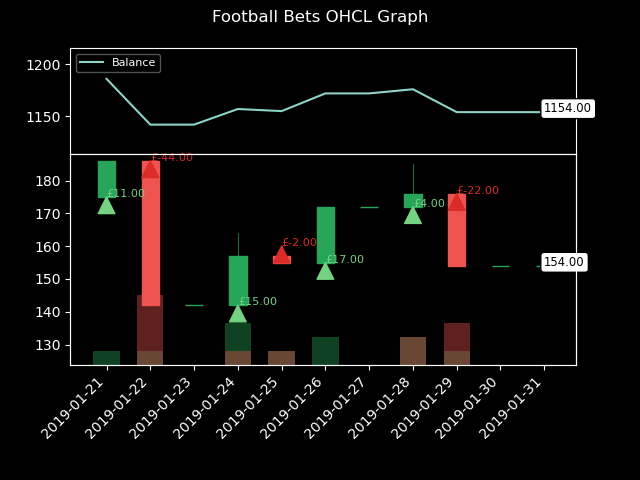

In [15]:
data = pd.read_excel('test_data.xlsx')

window_size = 10
visualization = None
current_step = 0
for index, row in data.iterrows():
    current_step = index
        
    if visualization is None or current_step == 0:
        visualization = FootballBettingGraph("Football Bets OHCL Graph", 
                                             starting_balance=1000,
                                             speed=0.5)
    visualization.update(current_step - 1, 
                         row['Date'],
                         row['Open'], 
                         row['High'], 
                         row['Close'], 
                         row['Low'], 
                         row['S Win Bets'] + row['S Lose Bets'] + row['S Draw Bets'],
                         row['F Win Bets'] + row['F Lose Bets'] + row['F Draw Bets'],
                         row['Profit'])
        
    if current_step > window_size:
        visualization.render(current_step - 1, window_size = 10)